# 1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Load Data

## Processing, Loading, and Padding the data

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def pad_slices(scan, target_slices= 30):
    # Get the current number of slices
    current_slices = scan.shape[0]
    # Check if padding is necessary
    if current_slices < target_slices:
        # Calculate padding amounts
        pad_before = (target_slices - current_slices) // 2
        pad_after = target_slices - current_slices - pad_before
        # Pad the scan with zeros on the slices axis (axis 0)
        padded_scan = np.pad(scan, pad_width=((pad_before, pad_after), (0, 0), (0, 0)), mode='constant', constant_values=0)
    elif current_slices > target_slices:
        # Calculate the cropping needed
        start = (current_slices - target_slices) // 2
        end = start + target_slices
        # Crop the scan to the target size
        padded_scan = scan[start:end, :, :]
    else:
        # If the number of slices is already equal to the target, no action is needed
        padded_scan = scan
    return padded_scan

## Load Data

In [5]:
def load_data(direc='', target_slices=30):
    # Directories for axial, coronal, and sagittal scans
    directories = [f'{direc}/axial', f'{direc}/coronal', f'{direc}/sagittal']
    data_all_angles = []

    for directory in directories:
        scans = []
        for scan_file in sorted(os.listdir(directory)):
            if scan_file.endswith('.npy'):
                path_to_scan = os.path.join(directory, scan_file)
                scan = np.load(path_to_scan, allow_pickle=True)
                padded_scan = pad_slices(scan, target_slices=target_slices)
                scans.append(padded_scan)

        data_all_angles.append(scans)
        print(f"Loaded {len(scans)} scans from {directory}")

    # Stack the processed data from different angles
    combined_data = [np.stack((axial, coronal, sagittal), axis=-1) 
                     for axial, coronal, sagittal in zip(*data_all_angles)]
    
    return np.array(combined_data)


In [6]:
# Use the load_data function
data = load_data(direc='data')

Loaded 1130 scans from data/axial
Loaded 1130 scans from data/coronal
Loaded 1130 scans from data/sagittal


## Load Labels

In [7]:
import pandas as pd

def load_labels(abnormal_path, acl_path, meniscus_path):
    # Load the entire CSV file and then drop the first column
    labels_abnormal = pd.read_csv(abnormal_path, header=None).drop(columns=0)
    labels_acl = pd.read_csv(acl_path, header=None).drop(columns=0)
    labels_meniscus = pd.read_csv(meniscus_path, header=None).drop(columns=0)

    # Convert to numpy arrays and ensure a 1-dimensional output
    labels_abnormal = labels_abnormal.squeeze().to_numpy()
    labels_acl = labels_acl.squeeze().to_numpy()
    labels_meniscus = labels_meniscus.squeeze().to_numpy()

    # Debugging: Print label shapes and sample labels
    print(f"Abnormal Labels Shape: {labels_abnormal.shape}")
    print(f"ACL Labels Shape: {labels_acl.shape}")
    print(f"Meniscus Labels Shape: {labels_meniscus.shape}")
    print("Sample Abnormal Labels:\n", labels_abnormal[:5])
    print("Sample ACL Labels:\n", labels_acl[:5])
    print("Sample Meniscus Labels:\n", labels_meniscus[:5])

    return labels_abnormal, labels_acl, labels_meniscus

# Example usage:
# abnormal_labels, acl_labels, meniscus_labels = load_labels(
#     'path_to_abnormal.csv', 'path_to_acl.csv', 'path_to_meniscus.csv'
# )


In [8]:
# Load labels
labels_abnormal, labels_acl, labels_meniscus= load_labels('labels/train-abnormal.csv', 'labels/train-acl.csv', 'labels/train-meniscus.csv')

Abnormal Labels Shape: (1130,)
ACL Labels Shape: (1130,)
Meniscus Labels Shape: (1130,)
Sample Abnormal Labels:
 [1 1 1 1 1]
Sample ACL Labels:
 [0 1 0 0 0]
Sample Meniscus Labels:
 [0 1 0 1 0]


## Combine Data and Labels

In [9]:
# Check data and labels
print(f"Loaded MRI Data Shape: {data.shape}")
print(f"Loaded Abnormal Labels Shape: {labels_abnormal.shape}")
print(f"Loaded ACL Labels Shape: {labels_acl.shape}")
print(f"Loaded Meniscus Labels Shape: {labels_meniscus.shape}")

Loaded MRI Data Shape: (1130, 30, 256, 256, 3)
Loaded Abnormal Labels Shape: (1130,)
Loaded ACL Labels Shape: (1130,)
Loaded Meniscus Labels Shape: (1130,)


## Use to display data

In [10]:

import matplotlib.pyplot as plt

def display_data(data, labels):
    # Display the first image of each angle from the combined data along with the labels
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # The data shape is expected to be (slices, 255, 255, angles)
    # We will display the middle slice for the current angle.
    middle_slice_index = data[0].shape[0] // 2

    for j, title in enumerate(('Axial', 'Coronal', 'Sagittal')):
        # Extract the middle slice for the current angle
        image = data[0][middle_slice_index, ..., j]
        axs[j].imshow(image, cmap='gray')
        axs[j].axis('off')  # Turn off axis
        axs[j].title.set_text(title)

    # Assuming labels is a list or numpy array with the label for each angle
    label_names = ['Abnormal', 'ACL', 'Meniscus']
    label_str = ', '.join(f"{name}: {value}" for name, value in zip(label_names, labels))
    plt.suptitle(f'Labels: {label_str}')

    # Show the plot
    plt.show()

# Example usage:
# Assuming 'data' is your MRI data and 'labels' is a list or array with the labels for the first image
# display_data(data, labels)


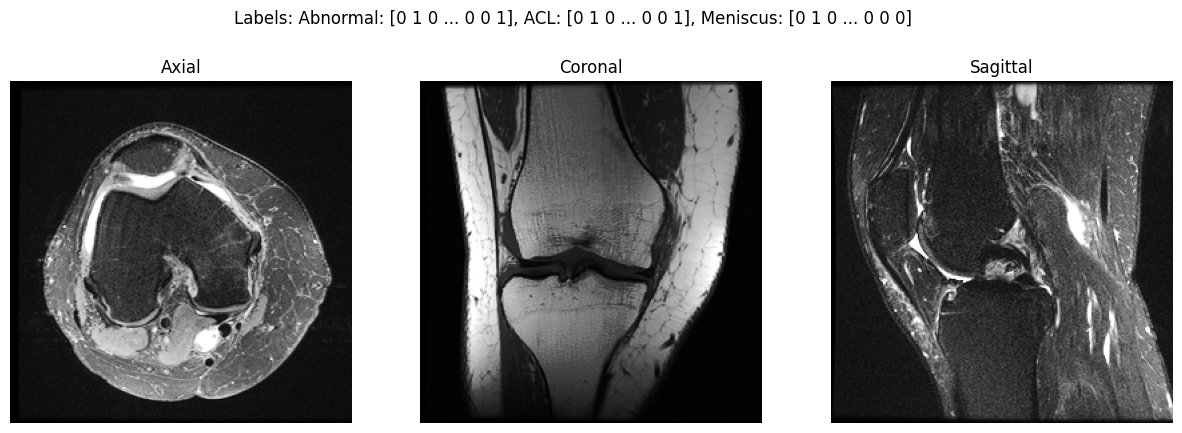

In [11]:
display_data(data, (labels_acl, labels_acl, labels_meniscus))

# 3. Preprocess Data (Crop, Scale, Augment)

## Cropping the Data

In [12]:
import numpy as np

def crop_center(img, cropx, cropy):
    # Assuming img has shape (slices, height, width, channels)
    d, y, x, c = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    
    # Ensure the cropped image has the same number of channels
    return img[:, starty:starty+cropy, startx:startx+cropx, :]

In [13]:



batch_size = 10  # Set your batch size

# Initialize a new array to hold the cropped images
cropped_data = np.zeros((data.shape[0], data.shape[1], 160, 160, data.shape[-1]), dtype=data.dtype)

# Loop over the data in batches for cropping
for start in range(0, len(data), batch_size):
    end = start + batch_size
    batch = data[start:end]

    # Apply cropping to each image in the batch
    cropped_batch = np.array([crop_center(img, 160, 160) for img in batch])

    # Update the cropped_data array with the cropped_batch
    cropped_data[start:end] = cropped_batch

    # Feedback to user
    print(f"Cropped batch from index {start} to {end}")

# Now 'cropped_data' contains the cropped images
# You can continue to use 'cropped_data' for further processing such as scaling


Cropped batch from index 0 to 10
Cropped batch from index 10 to 20
Cropped batch from index 20 to 30
Cropped batch from index 30 to 40
Cropped batch from index 40 to 50
Cropped batch from index 50 to 60
Cropped batch from index 60 to 70
Cropped batch from index 70 to 80
Cropped batch from index 80 to 90
Cropped batch from index 90 to 100
Cropped batch from index 100 to 110
Cropped batch from index 110 to 120
Cropped batch from index 120 to 130
Cropped batch from index 130 to 140
Cropped batch from index 140 to 150
Cropped batch from index 150 to 160
Cropped batch from index 160 to 170
Cropped batch from index 170 to 180
Cropped batch from index 180 to 190
Cropped batch from index 190 to 200
Cropped batch from index 200 to 210
Cropped batch from index 210 to 220
Cropped batch from index 220 to 230
Cropped batch from index 230 to 240
Cropped batch from index 240 to 250
Cropped batch from index 250 to 260
Cropped batch from index 260 to 270
Cropped batch from index 270 to 280
Cropped batc

In [14]:
data = cropped_data

In [15]:
del cropped_data

## Data Augmentation 

In [18]:
import numpy as np
import random

def random_rotation(img, max_rotations):
    # Rotate image by a random number of 90-degree steps
    k = random.randint(0, max_rotations)  # Choose a random rotation
    return np.rot90(img, k=k, axes=(0, 1))  # Rotate on the (height, width) plane

def horizontal_flip(img, flip_prob):
    # Flip image horizontally with a given probability
    if random.random() < flip_prob:
        return np.flip(img, axis=1)  # Flip on the width axis
    return img

# Set your batch size and other parameters
batch_size = 10
max_rotations = 3  # This will allow for 0, 90, 180, and 270 degrees of rotation
flip_prob = 0.5

for start in range(0, len(data), batch_size):
    end = min(start + batch_size, len(data))
    batch = data[start:end]

    # Apply augmentation to each slice in each scan
    augmented_batch = np.empty_like(batch)
    for scan_idx, scan in enumerate(batch):
        for slice_idx, img_slice in enumerate(scan):
            # No need to check for channel dimension for MRI data
            rotated = random_rotation(img_slice, max_rotations)
            flipped = horizontal_flip(rotated, flip_prob)
            augmented_batch[scan_idx, slice_idx] = flipped
    
    # Update the original data array with the augmented batch
    data[start:end] = augmented_batch

    print(f"Augmented batch from index {start} to {end}")


Augmented batch from index 0 to 10
Augmented batch from index 10 to 20
Augmented batch from index 20 to 30
Augmented batch from index 30 to 40
Augmented batch from index 40 to 50
Augmented batch from index 50 to 60
Augmented batch from index 60 to 70
Augmented batch from index 70 to 80
Augmented batch from index 80 to 90
Augmented batch from index 90 to 100
Augmented batch from index 100 to 110
Augmented batch from index 110 to 120
Augmented batch from index 120 to 130
Augmented batch from index 130 to 140
Augmented batch from index 140 to 150
Augmented batch from index 150 to 160
Augmented batch from index 160 to 170
Augmented batch from index 170 to 180
Augmented batch from index 180 to 190
Augmented batch from index 190 to 200
Augmented batch from index 200 to 210
Augmented batch from index 210 to 220
Augmented batch from index 220 to 230
Augmented batch from index 230 to 240
Augmented batch from index 240 to 250
Augmented batch from index 250 to 260
Augmented batch from index 260 t

# Split Data

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [17]:

# Assuming data and labels are numpy arrays
total_size = data.shape[0]

# Calculate the indices for splitting
train_end = int(train_size)
val_end = train_end + int(val_size)

# Split the data
trainD = data[:train_end]
valD = data[train_end:val_end]
testD = data[val_end:]


In [18]:

# ACL Label Split

# Split the labels
trainL_acl = labels_acl[:train_end]
valL_acl = labels_acl[train_end:val_end]
testL_acl = labels_acl[val_end:]

# Create tuples for easy handling
train_acl = (trainD, trainL_acl)
validation_acl = (valD, valL_acl)
test_acl = (testD, testL_acl)



In [19]:

# Meniscus Label Split

# Split the labels
trainL_meniscus = labels_meniscus[:train_end]
valL_meniscus = labels_meniscus[train_end:val_end]
testL_meniscus = labels_meniscus[val_end:]

# Create tuples for easy handling
train_meniscus = (trainD, trainL_meniscus)
validation_meniscus = (valD, valL_meniscus)
test_meniscus = (testD, testL_meniscus)



In [20]:
# Assuming data and labels are numpy arrays
total_size = data.shape[0]

# Calculate the indices for splitting
train_end = int(train_size)
val_end = train_end + int(val_size)

# Split the data
trainD = data[:train_end]
valD = data[train_end:val_end]
testD = data[val_end:]

# Split the labels
trainL = labels[:train_end]
valL = labels[train_end:val_end]
testL = labels[val_end:]

# Create tuples for easy handling
train = (trainD, trainL)
validation = (valD, valL)
test = (testD, testL)

# Check the shape of the datasets
print('Training set shape:', trainD.shape)
print('Validation set shape:', valD.shape)
print('Test set shape:', testD.shape)

NameError: name 'labels' is not defined

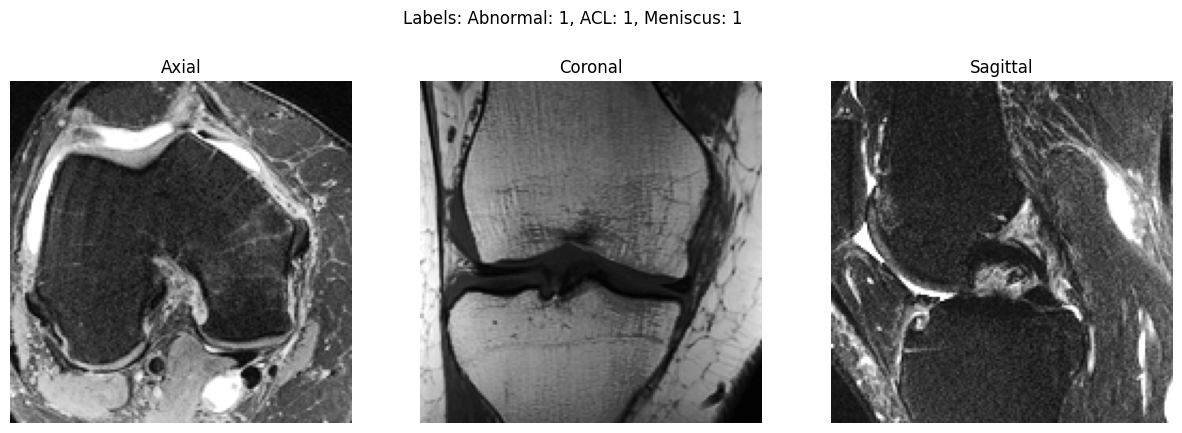

In [51]:
display_data(data, labels_abnormal)

## Data Generator (generates data in a sequence to help with training memory load)

In [52]:
from tensorflow.keras.utils import Sequence

In [53]:
class MRISequence(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
    
        return np.array(batch_x), np.array(batch_y)


In [54]:
# Assuming 'trainD' and 'trainL' are paths to your data or some lazy loading mechanism
train_seq_acl = MRISequence(trainD, trainL_acl, batch_size = 10)  # Adjust batch_size to a suitable value for your hardware
train_seq_meniscus = MRISequence(trainD, trainL_meniscus, batch_size = 10)  # Adjust batch_size to a suitable value for your hardware

# 4. Build Deep Learning Model

## Model 2 - Healthy v.s. ACL Tear

## For Binary Modeling

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv3D, MaxPooling3D, GlobalMaxPooling3D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

def build_binary_model(input_shape, num_classes):
    # Define the input layer
    inputs = Input(shape=input_shape)

    # Define a series of CONV => RELU => POOL layers
    x = Conv3D(32, (1, 1, 1), padding="same")(inputs)
    x = Activation("relu")(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = BatchNormalization()(x)

    # Add more CONV => RELU => POOL layers, if necessary
    x = Conv3D(64, (1, 1, 1), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = BatchNormalization()(x)

    # Add more layers according to your requirements

    # Final layers
    x = GlobalMaxPooling3D()(x)
    x = Dense(1024, activation="relu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation="softmax")(x)  # Using sigmoid for multi-label classification

    # Create the model
    model = Model(inputs=inputs, outputs=x)

    # Compile the model using binary cross-entropy rather than sparse categorical cross-entropy
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=["accuracy"])
    return model

# Usage
num_classes = 1  # Update this to the number of labels you have
input_shape = (30, 160, 160, 3)  # Update this to match your dataset input shape
modelACL = build_multilabel_model(input_shape, num_classes)




In [56]:
from keras.callbacks import EarlyStopping

In [57]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# 5. Train

In [33]:
# train loss / validation should go down, train accuracy and validation accuracy should go up

In [59]:
# Fit the model with early stopping
history = modelACL.fit(trainD, trainL_acl,
                    epochs=15, # Adjust the number of epochs as necessary
                    verbose=1,
                    callbacks=[early_stopping],
                    validation_data= validation_acl)

Epoch 1/15
25/25 [==============================] - 121s 4s/step - loss: 2.0942 - accuracy: 0.6890 - val_loss: 1.6650 - val_accuracy: 0.8230
Epoch 2/15
25/25 [==============================] - 101s 4s/step - loss: 1.9210 - accuracy: 0.7434 - val_loss: 1.5763 - val_accuracy: 0.8230
Epoch 3/15
25/25 [==============================] - 99s 4s/step - loss: 1.8494 - accuracy: 0.7345 - val_loss: 1.5807 - val_accuracy: 0.8230
Epoch 4/15
25/25 [==============================] - 98s 4s/step - loss: 1.7551 - accuracy: 0.7358 - val_loss: 1.5392 - val_accuracy: 0.8230
Epoch 5/15
25/25 [==============================] - 96s 4s/step - loss: 1.6962 - accuracy: 0.7585 - val_loss: 1.4645 - val_accuracy: 0.8230
Epoch 6/15
25/25 [==============================] - 101s 4s/step - loss: 1.6084 - accuracy: 0.7459 - val_loss: 1.4315 - val_accuracy: 0.8230
Epoch 7/15
25/25 [==============================] - 97s 4s/step - loss: 1.5779 - accuracy: 0.7396 - val_loss: 1.4003 - val_accuracy: 0.8230
Epoch 8/15
25/25 

# Save and Plot Performance

In [60]:
from tensorflow.keras.models import load_model

In [62]:
modelACL.save(os.path.join('models','ACLimageclassifier11.h5'))

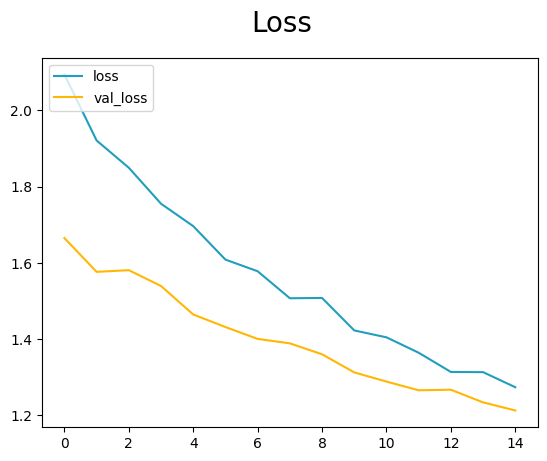

In [63]:
# Plot for loss
fig = plt.figure()
plt.plot(history.history['loss'], color='#219EBC', label='loss')  # Blue Green color
plt.plot(history.history['val_loss'], color='#FFB703', label='val_loss')  # Selective Yellow color
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

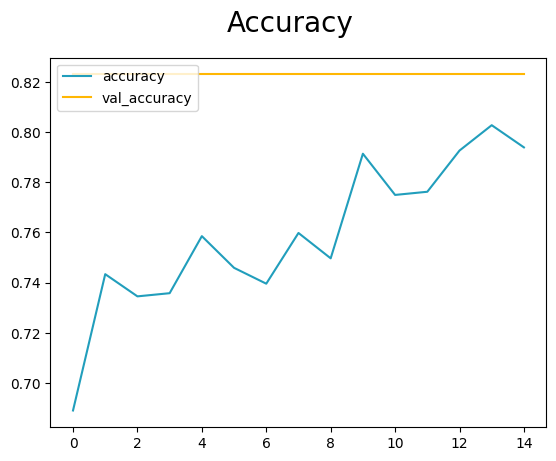

In [64]:
# Plot for accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='#219EBC', label='accuracy')  # Blue Green color
plt.plot(history.history['val_accuracy'], color='#FFB703', label='val_accuracy')  # Selective Yellow color
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 7. Save the Model using TFlite (optional)

In [99]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

# Initialize TFLiteConverter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Indicate that TensorFlow ops are allowed (enables the use of Flex ops)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # Enable TensorFlow ops.
]

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = os.path.join('models', 'model6.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f'Model is successfully converted to TensorFlow Lite and saved at {tflite_model_path}')


INFO:tensorflow:Assets written to: C:\Users\Jack\AppData\Local\Temp\tmp4d4b3_l1\assets


INFO:tensorflow:Assets written to: C:\Users\Jack\AppData\Local\Temp\tmp4d4b3_l1\assets


Model is successfully converted to TensorFlow Lite and saved at models\model6.tflite


# 8. Load an Existing Model

In [88]:
from tensorflow.keras.models import load_model
import os

model_path = os.path.join('models', 'ACLimageclassifier11.h5')
model = load_model(model_path)

In [89]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 160, 160, 3   0         
                             )]                                  
                                                                 
 conv3d_4 (Conv3D)           (None, 30, 160, 160, 32   2624      
                             )                                   
                                                                 
 activation_4 (Activation)   (None, 30, 160, 160, 32   0         
                             )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 15, 80, 80, 32)    0         
 g3D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 15, 80, 80, 32)    128 

# 9. Test

In [90]:
# Assuming 'model' is your trained model and 'X_test' is your test dataset
y_pred_probs = model.predict(testD)


4/4 [==============================] - 3s 713ms/step


In [91]:
from sklearn.metrics import roc_curve
import numpy as np

def find_optimal_thresholds(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)  # Calculate the distance to the top-left corner for each point on the ROC curve
    min_distance_idx = np.argmin(distances)  # Find the smallest distance and its corresponding index
    optimal_threshold = thresholds[min_distance_idx]
    print(f"Optimal threshold is: {optimal_threshold}")
    return optimal_threshold

# Example usage:
optimal_threshold = find_optimal_thresholds(testL_acl, y_pred_probs)



Optimal threshold is: 0.1571982055902481


In [92]:
def apply_thresholds_and_evaluate(y_true, y_pred_probs, threshold):
    # Apply threshold to prediction probabilities to create binary predictions
    y_pred = (y_pred_probs >= threshold).astype(int)

    # Determine which predictions match the true labels
    correctness = (y_pred == y_true).astype(int)

    # Calculate overall correctness (sum of correct predictions)
    overall_correctness = np.sum(correctness)

    # Calculate accuracy (proportion of correct predictions)
    accuracy = overall_correctness / len(y_true)

    print(f"Overall Correctness: {overall_correctness} out of {len(y_true)}")
    print(f"Accuracy: {accuracy:.2f}")

    return y_pred, correctness

# Example usage:
y_pred, correctness = apply_thresholds_and_evaluate(testL_acl, y_pred_probs, optimal_threshold)


Overall Correctness: 8004 out of 113
Accuracy: 70.83


In [93]:
correctness

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

# 6. Evaluate

In [94]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, AUC

In [95]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
auc = AUC()

In [96]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, AUC

# Initialize metrics for multi-label classification
precision = Precision()
recall = Recall()
binary_accuracy = BinaryAccuracy()
auc = AUC()

# Assuming 'model' is your trained multi-label classification model 
# and 'test_data' and 'test_labels' are your test datasets.

# Make predictions
predictions = modelACL.predict(testD)

# Convert predictions to binary using a threshold (usually 0.5 for sigmoid outputs)
binary_predictions = (predictions > optimal_threshold).astype(int)

# Update metrics
precision.update_state(testL_acl, binary_predictions)
recall.update_state(testL_acl, binary_predictions)
binary_accuracy.update_state(testL_acl, binary_predictions)
auc.update_state(testL_acl, binary_predictions)

# Calculate final results
precision_result = precision.result().numpy()
recall_result = recall.result().numpy()
accuracy_result = binary_accuracy.result().numpy()
auc_result = auc.result().numpy()

# Print results
print(f"Precision: {precision_result:.4f}, Recall: {recall_result:.4f}, "
      f"Accuracy: {accuracy_result:.4f}, AUC: {auc_result:.4f}")


4/4 [==============================] - 3s 726ms/step
Precision: 0.2857, Recall: 0.5882, Accuracy: 0.7168, AUC: 0.6639
